# Multi-instrument fitting

In this notebook, we will demonstrate `juliet`'s capability of simultaneously fitting multiple instruments with joint transit and eclipse model.

- Data used: WASP-18, TESS Sector 2 and 3 (Data can be found in the 'Data' folder)
- Model: Transit and Eclipse model
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd

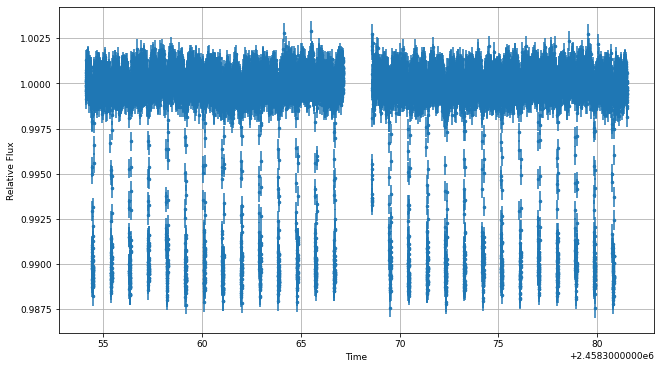

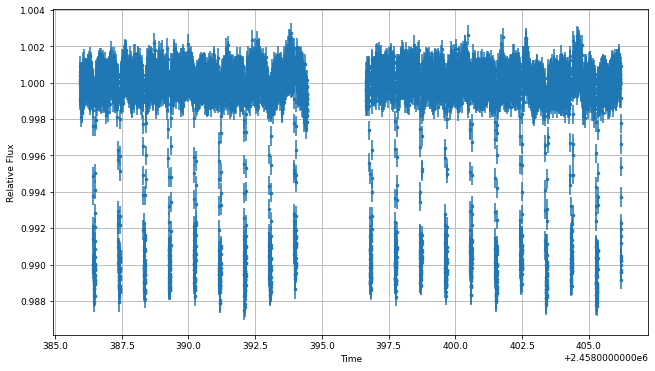

In [2]:
# Let's first load and visualise the data
tim1, fl1, fle1 = np.loadtxt(os.getcwd() + '/Data/WASP-18_TESS2.dat',\
    usecols=(0,1,2), unpack=True)
tim3, fl3, fle3 = np.loadtxt(os.getcwd() + '/Data/WASP-18_TESS3.dat',\
    usecols=(0,1,2), unpack=True)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.grid()
plt.show()

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim3, fl3, yerr=fle3, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.grid()
plt.show()

The data looks nice! Transits of the planet is clearly visible.

In [3]:
# Converting data products in dictionary, so that juliet can understand it!
tim, fl, fle = {}, {}, {}
tim['TESS2'], fl['TESS2'], fle['TESS2'] = tim1, fl1, fle1
tim['TESS3'], fl['TESS3'], fle['TESS3'] = tim3, fl3, fle3

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp`
- Include LDCs.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. And we have two instruments: TESS2 and TESS3. In the present examples, we keep the same planet-to-star radius ratio for both of the instruments. To do so, we will use `p_p1_TESS2_TESS3` in prior list.
- We do the same for the eclipse depth: we will use the same `fp_p1` for both instruments by using `fp_p1_TESS2_TESS3` in the priors.
- Note also that while listing priors for `p` and `fp`, the planet number goes _before_ instrument. That means, `p_p1_TESS2` is valid, but `p_TESS2_p1` is not valid.
- In this example, we share `p_p1` for both instruments, but this is not necessary. One can provide different `p_p1` for both instruments. Same goes for `fp_p1`.
- Although `fp` is planetary _and_ instrumental parameter, the light travel correction factor is still _only_ planetary parameter, i.e., we will use `ac_p1`.

In [4]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
ac1 = 0.0001169                        # Computed from a = 0.02024 AU and c
## Computing transit time for the epoch from the data
cycle = round((tim1[-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc0, tc0_err = np.median(tc1), np.std(tc1)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_TESS2_TESS3', 'b_p1', 'q1_TESS2_TESS3', 'q2_TESS2_TESS3',\
     'a_p1', 'fp_p1_TESS2_TESS3', 'ac_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform',\
     'loguniform', 'uniform', 'fixed', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, 0.1], [0., 1.], [0., 1.], [0.,1.], [0.,1.],\
     [1., 10.], [0.e-6, 500.e-6], ac1, 0., 90.]

## Instrumental and GP parameters
par_ins = ['mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2',\
     'mdilution_TESS3', 'mflux_TESS3', 'sigma_w_TESS3']
dist_ins = ['fixed', 'normal', 'loguniform', 'fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.], 1., [0., 0.1], [0.1, 10000.]]

par_gp = ['GP_sigma_TESS2', 'GP_timescale_TESS2', 'GP_rho_TESS2',\
     'GP_sigma_TESS3', 'GP_timescale_TESS3', 'GP_rho_TESS3']
dist_gp = ['loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2], [1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [5]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Multi-Transit-Eclipse_1')
res = dataset.fit(sampler = 'dynesty')

30480it [1:01:23,  8.28it/s, +500 | bound: 383 | nc: 1 | ncall: 1107386 | eff(%):  2.799 | loglstar:   -inf < 189936.429 <    inf | logz: 189876.036 +/-  0.349 | dlogz:  0.001 >  0.509]


In [6]:
os.system("cat Analysis/Multi-Transit-Eclipse_1/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414522202 	 	 0.0000002387 	 	 0.0000002379
t0_p1              	 	 2458381.7600055756 	 	 0.0000247257 	 	 0.0000254572
p_p1_TESS2_TESS3   	 	 0.0981418182 	 	 0.0002917815 	 	 0.0003126457
b_p1               	 	 0.3812066818 	 	 0.0172523542 	 	 0.0185722007
q1_TESS2_TESS3     	 	 0.1956738932 	 	 0.0249981831 	 	 0.0220059160
q2_TESS2_TESS3     	 	 0.3626862016 	 	 0.0571768323 	 	 0.0521484096
a_p1               	 	 3.4666468158 	 	 0.0223664679 	 	 0.0226468769
fp_p1_TESS2_TESS3  	 	 0.0003553645 	 	 0.0000194938 	 	 0.0000192101
mflux_TESS2        	 	 0.0021414699 	 	 0.0036830207 	 	 0.0033664396
sigma_w_TESS2      	 	 1.4305828035 	 	 7.8839208800 	 	 1.1908973172
mflux_TESS3        	 	 -0.0018492221 	 	 0.0035343629 	 	 0.0040919324
sigma_w_TESS3      	 	 1.9285325658 	 	 10.5665662550 	 	 1.6689975008
GP_sigma_TESS2     	 	 0.0000224761 	 	 0.0000358402 	 	 0.0000100886
GP_timesca

0

le_TESS2 	 	 0.0138868974 	 	 0.0108008774 	 	 0.0085486488
GP_rho_TESS2       	 	 61.0623998144 	 	 25.2437497185 	 	 25.3517945417
GP_sigma_TESS3     	 	 0.0000231876 	 	 0.0000421937 	 	 0.0000103352
GP_timescale_TESS3 	 	 0.0128383799 	 	 0.0104195290 	 	 0.0083481092
GP_rho_TESS3       	 	 56.4640974251 	 	 27.3894566549 	 	 25.2787987911


The posteriors look good for most of the planetary parameters and seems to agree with their corresponding values from the literature.

Let's now visualise our results to make sure that everything was smooth.

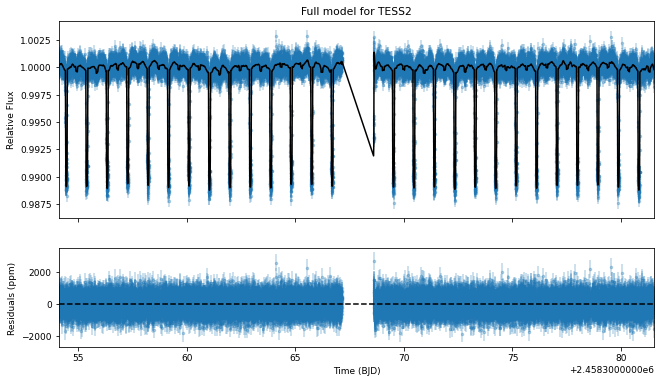

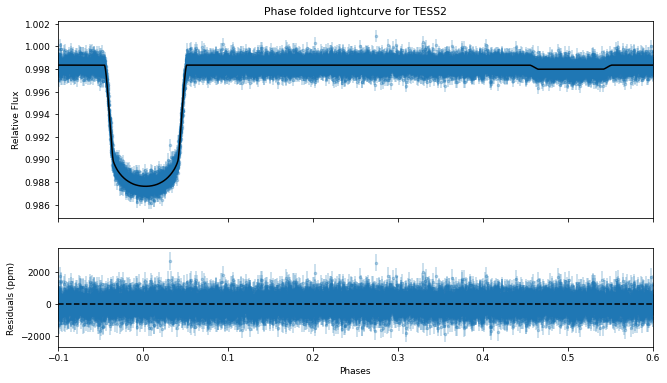

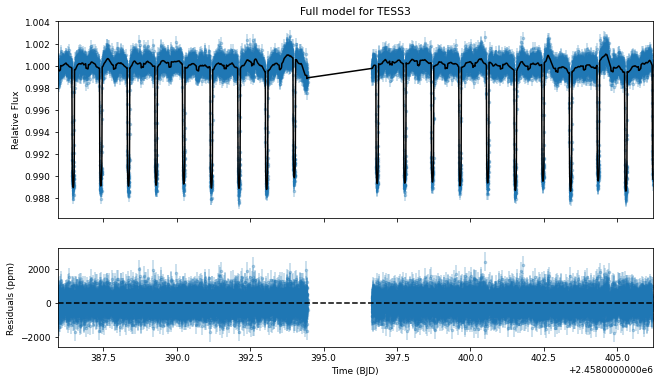

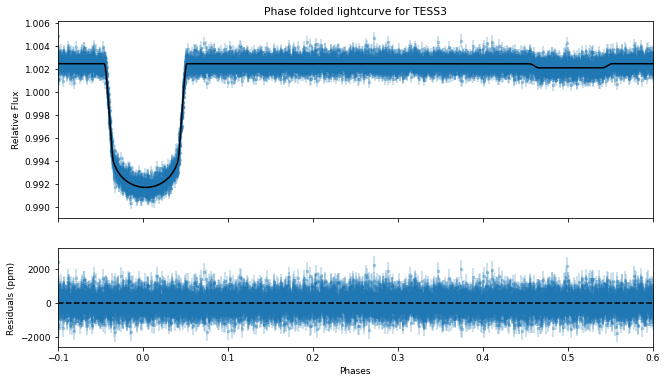

In [7]:
for i in ['TESS2', 'TESS3']:
    # juliet best fit model
    model = res.lc.evaluate(i)
    gp_model = res.lc.model[i]['GP']
    transit_model = res.lc.model[i]['deterministic']
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(tim[i], model, c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(np.min(tim[i]), np.max(tim[i]))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(tim[i], (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_xlim(np.min(tim[i]), np.max(tim[i]))

    ax1.set_title('Full model for ' + i)
    plt.show()

    # Phase folded lightcurves:
    phs = juliet.utils.get_phases(tim[i], per, bjd0, phmin=0.8)
    idx = np.argsort(phs)
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(phs, fl[i]-gp_model, yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(-0.1, 0.6)
    #ax1.set_ylim(0.998, 1.002)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(phs, (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Phases')
    ax2.set_xlim(-0.1, 0.6)

    ax1.set_title('Phase folded lightcurve for ' + i)
    plt.show()

This is fantastic!